In [1]:
#Import libraries
library(ggplot2) # Data visualization
library(RSQLite)
library(plyr)
library(dplyr, warn.conflicts = FALSE)

#Connect to the database 
db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

skill_stats <- c(
    'height',
    'weight',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'free_kick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'balance',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
    'aggression',
    'interceptions',
    'positioning',
    'vision',
    'penalties',
    'marking',
    'standing_tackle',
    'sliding_tackle',
    'gk_diving',
    'gk_handling',
    'gk_kicking',
    'gk_positioning',
    'gk_reflexes'
)

attributes <- c(
    'player_name',
    'date',
    'Player.player_fifa_api_id',
    'Player.player_api_id',
    'preferred_foot',
    'attacking_work_rate',
    'defensive_work_rate',
    skill_stats
)
cols <- paste(attributes, collapse=",")

Player <- dbGetQuery(db, sprintf("SELECT %s FROM Player JOIN Player_Attributes ON Player.player_api_id = Player_Attributes.player_api_id", cols))

#Count the number of matches the particular team played at home
home_match = count(Match,home_team_api_id)
away_match = count(Match,away_team_api_id)
#change names of the column n to number of matches
names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

In [2]:
head(Player)

player_name,date,player_fifa_api_id,player_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,height,weight,overall_rating,⋯,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
Aaron Appindangoye,2016-02-18 00:00:00,218353,505942,right,medium,medium,182.88,187,67,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-11-19 00:00:00,218353,505942,right,medium,medium,182.88,187,67,⋯,54,48,65,69,69,6,11,10,8,8
Aaron Appindangoye,2015-09-21 00:00:00,218353,505942,right,medium,medium,182.88,187,62,⋯,54,48,65,66,69,6,11,10,8,8
Aaron Appindangoye,2015-03-20 00:00:00,218353,505942,right,medium,medium,182.88,187,61,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Appindangoye,2007-02-22 00:00:00,218353,505942,right,medium,medium,182.88,187,61,⋯,53,47,62,63,66,5,10,9,7,7
Aaron Cresswell,2016-04-21 00:00:00,189615,155782,left,high,medium,170.18,146,74,⋯,66,59,76,75,78,14,7,9,9,12


In [3]:
# Combine these two dataframes
new_match_data <- cbind(home_match, away_match)

new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    points = 0,
    points_average = 0,
    country = "",
    team_name = ""
)

#Find the country of the team and append in the country coloumn
for(row1 in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(row1)])
    new_match_data$country[as.numeric(row1)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(row1)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(row1)]]
}
#Drop the unnecessary columns "home_matches_number" and "away_matches_number"
drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

print("Removed unnecessary columns")
print(head(new_match_data))

[1] "Removed unnecessary columns"
  home_team_api_id away_team_api_id total_matches wins win_percentage points
1             1601             1601           240    0              0      0
2             1773             1773            90    0              0      0
3             1957             1957           240    0              0      0
4             2033             2033           150    0              0      0
5             2182             2182           240    0              0      0
6             2183             2183           150    0              0      0
  points_average  country             team_name
1              0   Poland          Ruch Chorzów
2              0  Belgium   Oud-Heverlee Leuven
3              0   Poland Jagiellonia Białystok
4              0 Portugal        S.C. Olhanense
5              0   Poland           Lech Poznań
6              0   Poland           P. Warszawa


In [4]:
#Iterate over all the teams ids 
for(id in rownames(new_match_data)) {
    # win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count <- 0
    points <- 0
    #Find all the records in main "Match" table which match the current team id
    home_indexes <- which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes <- which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i] > Match$away_team_goal[i])
        {
            win_count <- win_count +1
            points <- points + 3
        }
        
        if (Match$home_team_goal[i] == Match$away_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    for(i in away_indexes)
    {
        if (Match$away_team_goal[i] > Match$home_team_goal[i])
        {
            win_count <- win_count + 1
            points <- points + 3
        }
        
        if (Match$away_team_goal[i] == Match$home_team_goal[i])
        {
            points <- points + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$points[as.numeric(id)] <- points
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
    new_match_data$points_average[as.numeric(id)] <- as.double(points/new_match_data$total_matches[as.numeric(id)])
}

# Drop Away_team_id column and change home_team_api_id columns name to team_id
drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"

#Sort the teams based on the winning percentage
sorted_teams_by_wins <- new_match_data[order(-new_match_data$win_percentage),]
sorted_teams_by_points <- new_match_data[order(-new_match_data$points_average),]

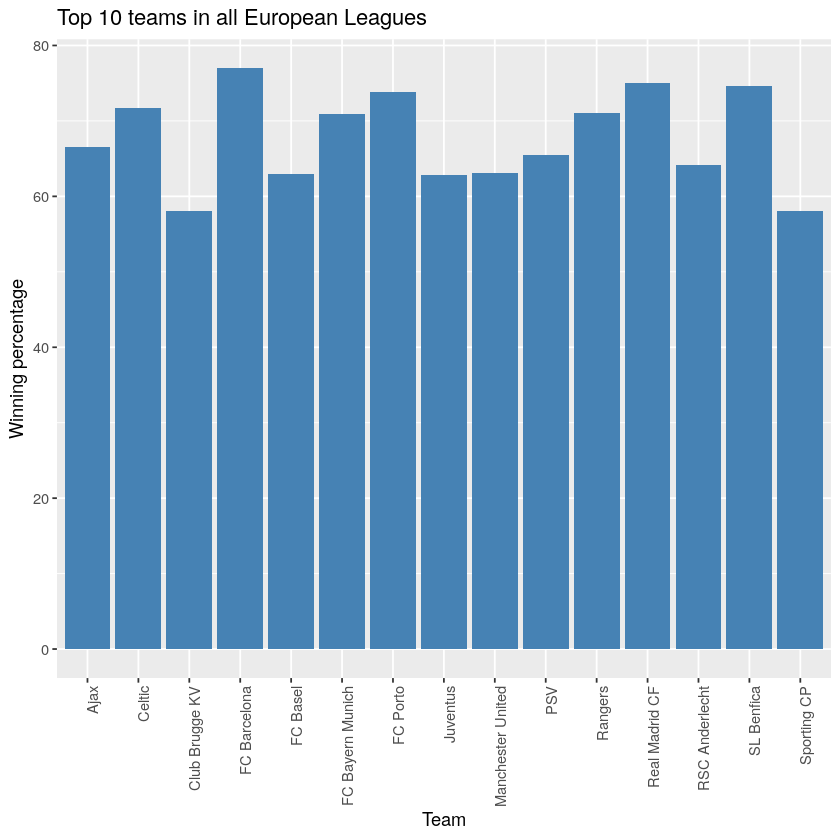

In [5]:
ggplot(data=sorted_teams_by_wins[0:15,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))


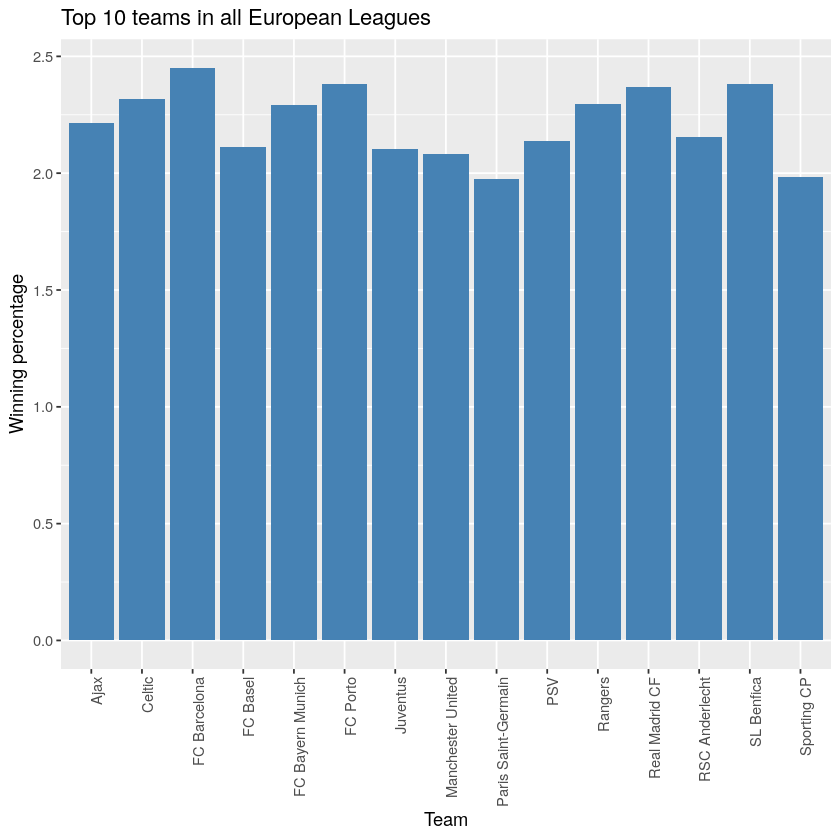

In [6]:
ggplot(data=sorted_teams_by_points[0:15,], aes(x=team_name,y=points_average)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [23]:
plot_top_teams <- function(n, country) {
    league_team <- sorted_teams_by_points[sorted_teams_by_points$country==country,]
    league <- league_team[order(-league_team$points_average),][1:n,]
    ggplot(data=league,aes(x=team_name,y=points_average))+
    geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Average Points")+
    ggtitle(sprintf("Top %d Teams in %s League", n, country))+theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

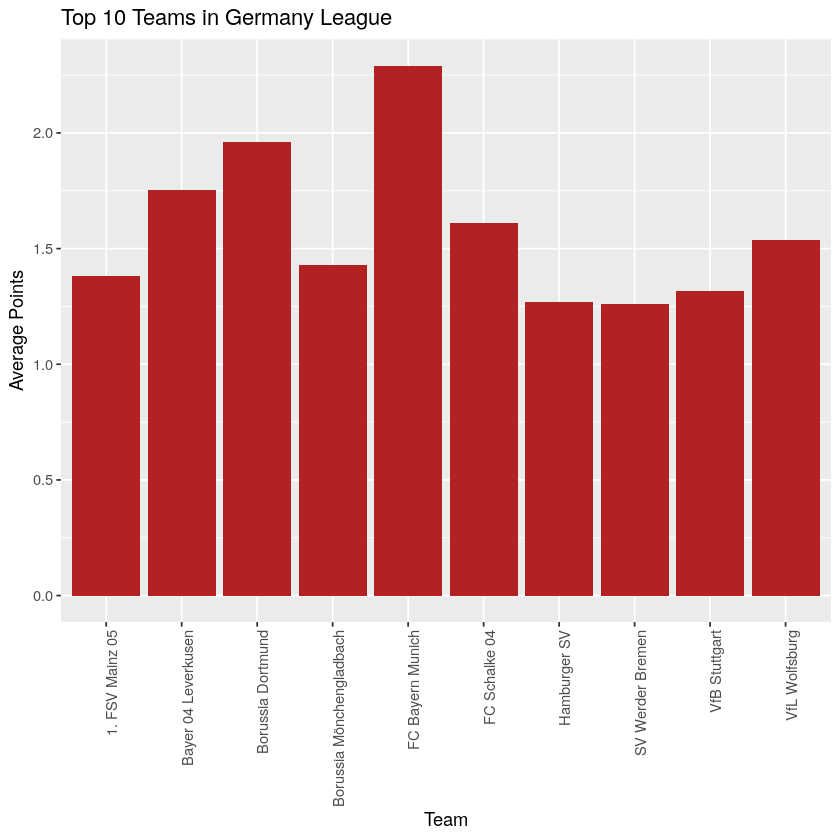

In [24]:
plot_top_teams(10, "Germany")

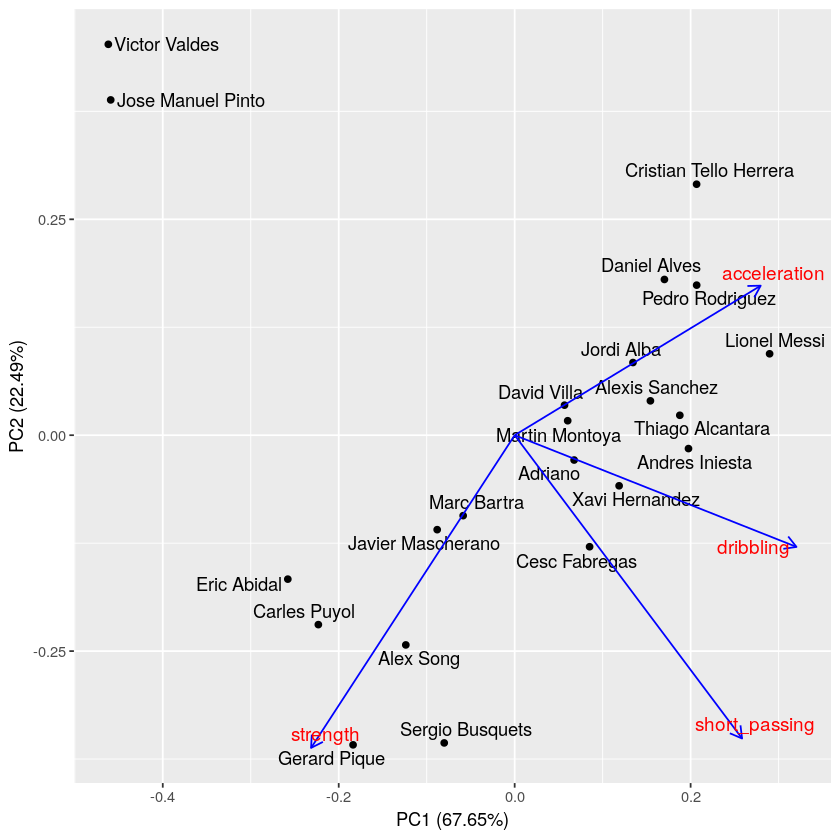

In [28]:
get_team_players_by_name <- function(team_name) {
    query <- paste0("SELECT * FROM Team WHERE team_long_name LIKE '%", team_name, "%'")
    team_api_id <- dbGetQuery(db, query)$team_api_id
    home_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE home_team_api_id = %s", team_api_id))
    away_team_matches <- dbGetQuery(db, sprintf("SELECT * FROM Match WHERE away_team_api_id = %s", team_api_id))

    # remove fields with nulls
    home_team_matches <- na.omit(home_team_matches)
    away_team_matches <- na.omit(away_team_matches)

    # get the player attributes closest to the date
    get_player_attributes <- function(player_api_id, match_date = Sys.Date()) {
        versions <- Player[Player$player_api_id == player_api_id,]
        versions[order(abs(difftime(versions$date, match_date))),][1,]
    }
    all_players <- list()
    for (i in 1:11) {
        home_players <- as.list(home_team_matches[sprintf("home_player_%d", i)])
        away_players <- as.list(away_team_matches[sprintf("away_player_%d", i)])
        all_players <- append(unlist(all_players), unlist(home_players))
        all_players <- append(unlist(all_players), unlist(away_players))
    }
    all_players <- unique(all_players)
    # construct the dataframe
    team_df <- do.call(rbind, Map(function(x) data.frame(get_player_attributes(x)), x=all_players))
    # use player's name instead of numeric index
    rownames(team_df) <- team_df$player_name
    team_df
}
                                  
plot_pca_for_team <- function(team_name, attributes) {
    players_df <- get_team_players_by_name(team_name)
    pca <- prcomp(players_df[,attributes], center = TRUE,scale. = TRUE)
    library(ggrepel)  
    library(ggfortify)
    autoplot(pca, label = TRUE, label.repel = T, loadings = TRUE, loadings.colour = 'blue', loadings.label = TRUE, 
         loadings.label.size = 4, loading.label.color = 'red',loadings.label.repel=TRUE) 
}
plot_pca_for_team("Barcelona", c("acceleration", "short_passing", "strength", "dribbling"))

Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ


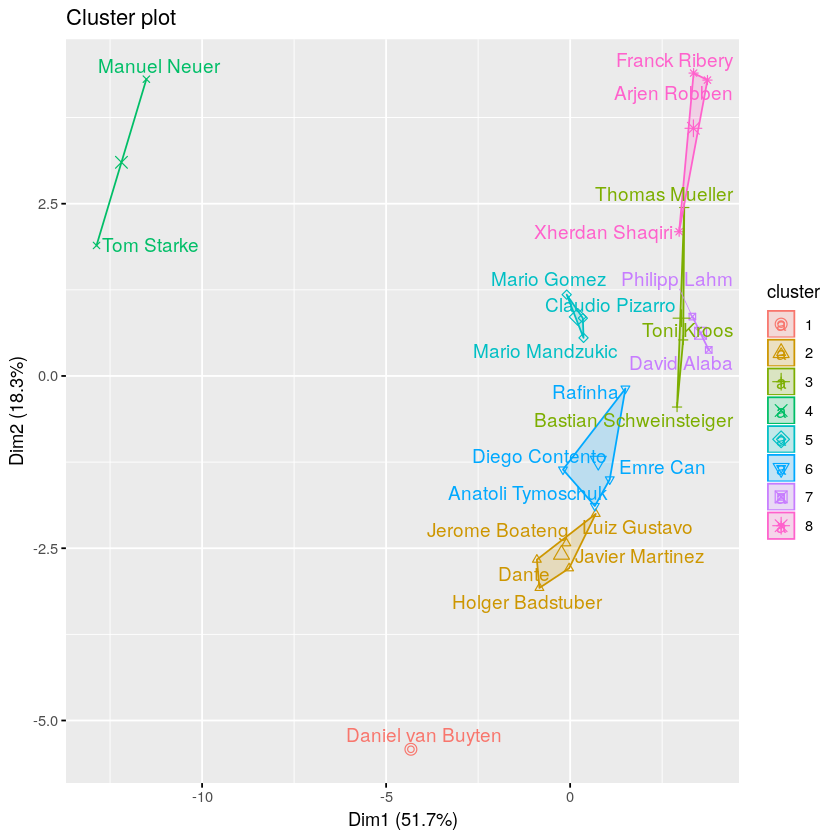

In [29]:
plot_clusters_for_team <- function(team_name, centers=5) {
    library(cluster)    # clustering algorithm
    library(factoextra) # visualization
    players_df <- get_team_players_by_name(team_name)
    players_df[skill_stats] <- scale(players_df[skill_stats])
    k5 <- kmeans(players_df[skill_stats], centers=centers, nstart = 25)
    fviz_cluster(k5, data = players_df, choose.vars=skill_stats, repel=TRUE) # prevent text overlapping
}

plot_h_clusters_for_team <- function(team_name) {
    players_df <- get_team_players_by_name(team_name)
    clusters <- hclust(dist(players_df[skill_stats]))
    plot(clusters,, main="Field positions hierarchy by skill stats")
}

plot_clusters_for_team("Bayern", 8)

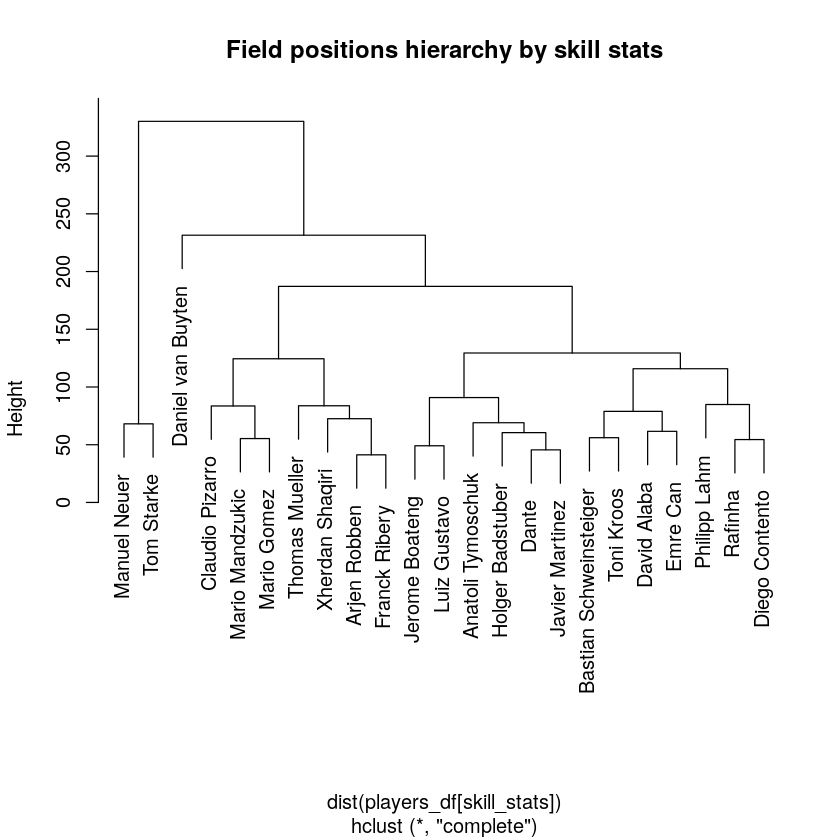

In [30]:
plot_h_clusters_for_team("Bayern")

In [143]:
library(caret)

matches <- na.omit(data.frame(Match))

betting.cols <- colnames(matches)[toupper(colnames(matches)) == colnames(matches)]
goals.diff <- matches$home_team_goal - matches$away_team_goal


matches$outcome <- ifelse(goals.diff == 0, 'D', ifelse(goals.diff > 0, 'W', 'L'))
matches <- matches[c(betting.cols, 'outcome')]

test.train <- createDataPartition(y=matches$outcome,p=0.8,list=FALSE)
train <- matches[test.train,]
test <- matches[-test.train,]

head(train)

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,⋯,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,outcome
3249,1.40,4.50,8.50,1.35,4.60,9.00,1.35,4.5,7.3,1.40,⋯,1.44,4.75,8.50,1.35,4.60,9.00,1.40,4.33,8.50,D
3252,1.17,7.00,17.00,1.18,6.25,16.00,1.17,5.8,13.0,1.17,⋯,1.20,7.00,19.00,1.18,6.25,16.00,1.17,6.50,17.00,W
3253,2.50,3.40,2.75,2.60,3.30,2.75,2.40,3.2,2.7,2.60,⋯,2.62,3.40,2.75,2.60,3.30,2.75,2.50,3.40,2.70,W
3254,2.00,3.40,3.80,2.00,3.40,3.60,2.10,3.3,3.1,2.00,⋯,2.00,3.50,4.00,2.00,3.40,3.60,2.00,3.40,3.60,L
3255,2.38,3.25,3.10,2.40,3.20,3.10,2.40,3.2,2.7,2.40,⋯,2.40,3.30,3.25,2.40,3.20,3.10,2.30,3.30,3.10,D
3256,4.20,3.50,1.91,4.10,3.50,1.85,3.30,3.3,2.0,3.75,⋯,4.33,3.60,1.95,4.10,3.50,1.85,4.00,3.40,1.91,W


In [144]:
library(e1071)
model <- svm(train$outcome ~ ., data = train, type = 'C')

In [145]:
model
pred <- predict(model, test)
xtab <- table(pred, test$outcome)
confusionMatrix(xtab)


Call:
svm(formula = train$outcome ~ ., data = train, type = "C")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.03333333 

Number of Support Vectors:  1184


Confusion Matrix and Statistics

    
pred   D   L   W
   D   0   0   0
   L  18  47  20
   W  73  53 140

Overall Statistics
                                          
               Accuracy : 0.5328          
                 95% CI : (0.4791, 0.5859)
    No Information Rate : 0.4558          
    P-Value [Acc > NIR] : 0.002301        
                                          
                  Kappa : 0.2021          
 Mcnemar's Test P-Value : < 2.2e-16       

Statistics by Class:

                     Class: D Class: L Class: W
Sensitivity            0.0000   0.4700   0.8750
Specificity            1.0000   0.8486   0.3403
Pos Pred Value            NaN   0.5529   0.5263
Neg Pred Value         0.7407   0.8008   0.7647
Prevalence             0.2593   0.2849   0.4558
Detection Rate         0.0000   0.1339   0.3989
Detection Prevalence   0.0000   0.2422   0.7578
Balanced Accuracy      0.5000   0.6593   0.6077

In [80]:
players.df <- get_team_players_by_name('Bayern')
players.df <- scale(players.df[skill_stats])

nclusters <- 8
km.res <- kmeans(players.df, nclusters, nstart = 25)

### Sensitivity Analysis ###
table(km.res$cluster)

km.gr <- data.frame(Name = names(km.res$cluster), gr=km.res$cluster)

# variabila folosita pentru a echivala grupele din seturi de grupari
# ATENTIE: grupa 1 in set 1 poate fi o alta grupa in set 2!
gr.match <- data.frame(orig=unique(km.gr$gr), m=0)

seed.sample <- sample(1:10000, 100, replace=FALSE)


for (seed in seed.sample) {
    set.seed(seed)
    km.res2 <- kmeans(players.df, nclusters, nstart = 25)
    km.gr2 <- data.frame(Name = names(km.res2$cluster), gr=km.res2$cluster)

    for(gr in unique(km.gr$gr)) {
        tmp.names <- km.gr$Name[km.gr$gr == gr]
        tmp <- km.gr2[ km.gr2$Name %in% tmp.names , ]
        # print(head(tmp))
        tbl <- table(tmp$gr)
        gr.max.id <- as.numeric(names(tbl)[tbl == max(tbl)])
        gr.match[gr.match$orig == gr, "m"] <- gr.max.id
    }

    km.gr2.std <- data.frame(Name = km.gr2$Name, gr=0)
    for(gr in unique(km.gr2$gr)) {
        sel <- km.gr2$gr == gr
        km.gr2.std[sel , "gr"] <- gr.match[gr.match$m == gr, "orig"]
    }
    # TODO: proper Join
    km.gr[ , paste0("gr", seed)] <- km.gr2.std$gr
}


multiple_classes_f <- function(x.data) {
    if(length(unique(x.data[-1])) != 1) {
        return(1)
    }
    return(0)
}

count_differences_f <- function(x.data) {
    return (length(x.data) - sort(table(x.data),decreasing=TRUE)[1])
}

# identiicam randurile care contin 2 sau mai multe grupe
gr.diff <- apply(km.gr, MARGIN=1, multiple_classes_f)
table(gr.diff)

# numaram cat de des sunt grupate diferit
gr.dif.cnt <- apply(km.gr[gr.diff != 0 ,], MARGIN=1, count_differences_f)
print("Wrong")
table(gr.dif.cnt)
# fonturi in grupe multiple
# mai mult de cel putin 10 ori
print("DSADSA")
gr.dif.cnt[gr.dif.cnt >= 5]


1 2 3 4 5 6 7 8 
3 2 3 5 1 2 3 4 

gr.diff
 0 
23 

[1] "Wrong"


< table of extent 0 >

[1] "DSADSA"


named integer(0)

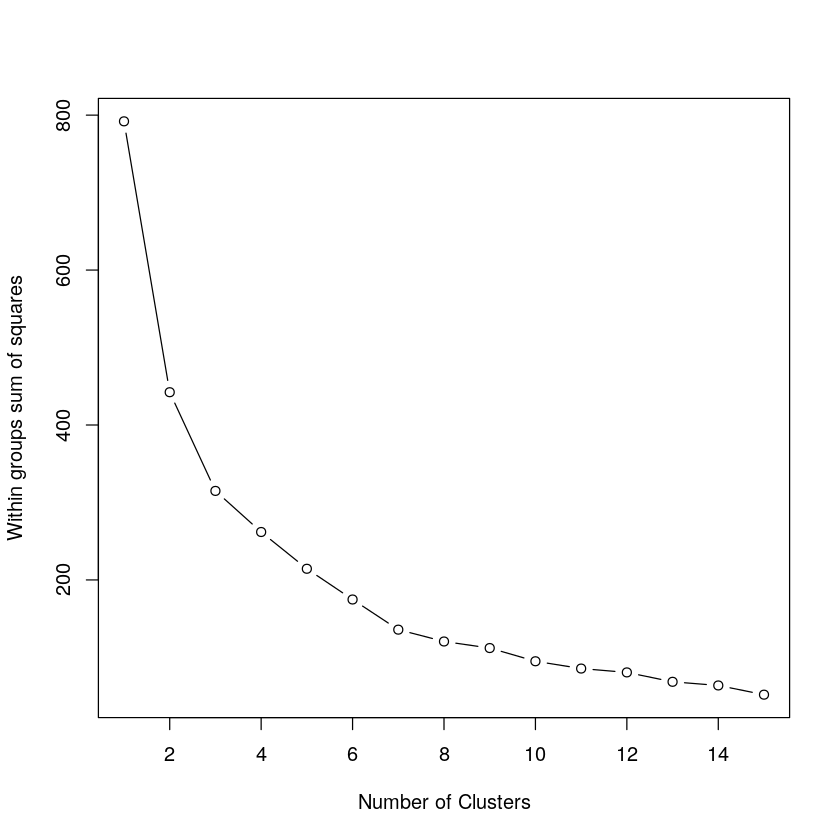

In [36]:
# Determine number of clusters
# folosind metoda elbow
wss <- (nrow(players.df) - 1) * sum(apply(players.df,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(players.df,
   centers=i)$withinss)
plot(1:15, wss, type="b", xlab="Number of Clusters",
  ylab="Within groups sum of squares")

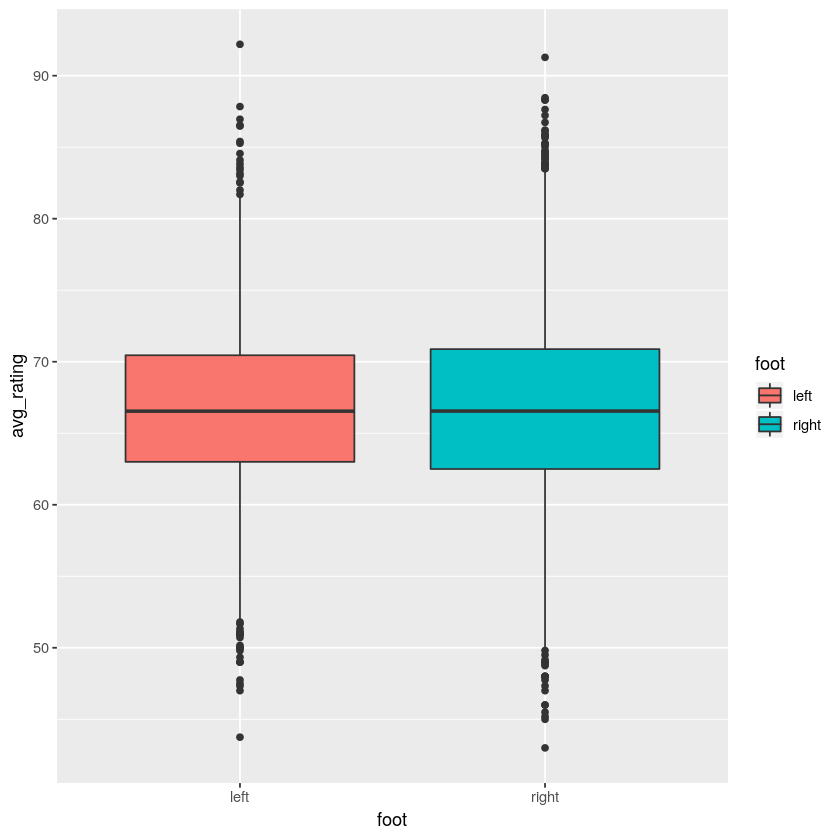

In [37]:
comparison <- Player %>%
  select(player_name, overall_rating, preferred_foot) %>%
  group_by(player_name) %>%
  summarise(avg_rating = mean(overall_rating), foot = names(which.max(table(preferred_foot))))

# make it a data.frame, so ggplot likes it
comparisonDF <- as.data.frame(comparison)

# check for NA's
# which(is.na(comparisonDF$avg_rating))

# There are 4 of them, so let us remove them
idx <- which(is.na(comparisonDF$avg_rating))
comparisonDF <- comparisonDF[-idx,]



# produce boxplot with ggplot
ggplot(comparisonDF, aes(fill = foot)) + 
    geom_boxplot(aes(x = foot, y = avg_rating))


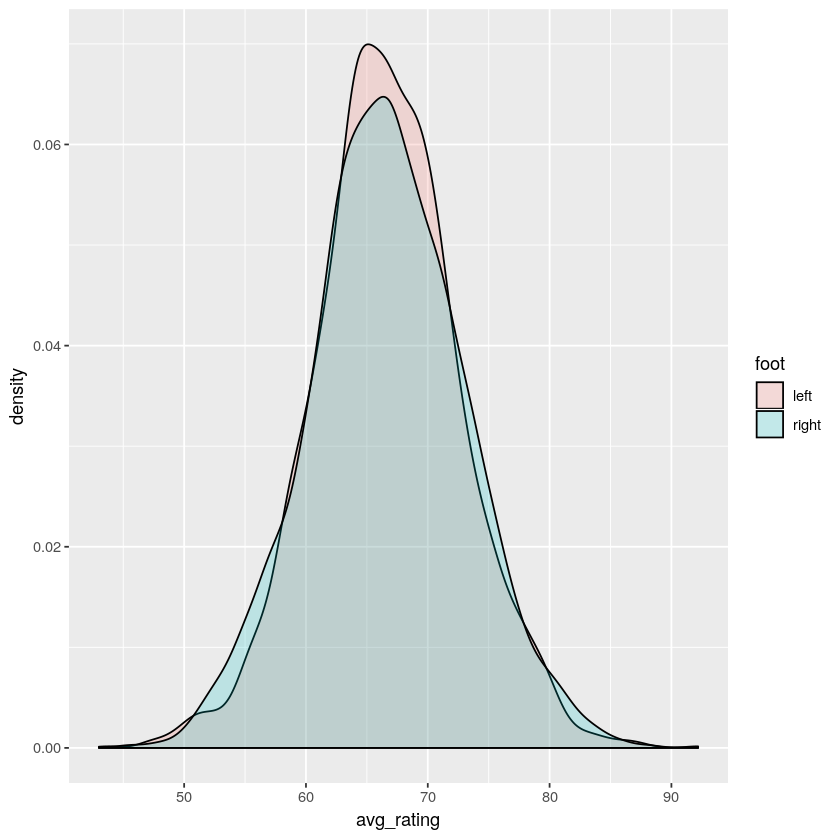

In [38]:
ggplot(comparisonDF, aes(x = avg_rating, fill = foot)) + 
    geom_density(alpha = 0.2)

In [39]:
lefties <- comparison %>%
  filter(foot == "left") %>%
  arrange(desc(avg_rating))

righties <- comparison %>%
  filter(foot == "right") %>%
  arrange(desc(avg_rating))

ks.test(lefties$avg_rating, righties$avg_rating)

Warning message in ks.test(lefties$avg_rating, righties$avg_rating):
“p-value will be approximate in the presence of ties”


	Two-sample Kolmogorov-Smirnov test

data:  lefties$avg_rating and righties$avg_rating
D = 0.029074, p-value = 0.08731
alternative hypothesis: two-sided
